In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

In [28]:
trainPath = 'C:\\Users\\sazid\\Desktop\\data\\snake_background_CNN2\\train'
valPath = 'C:\\Users\\sazid\\Desktop\\data\\snake_background_CNN2\\valid'
testPath = 'C:\\Users\\sazid\\Desktop\\data\\snake_background_CNN2\\test'

In [29]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean
testAug

array([123.68 , 116.779, 103.939], dtype=float32)

In [30]:
# initialize the training generator
batch_size = 32
trainGen = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size)
# initialize the validation generator
valGen = valAug.flow_from_directory(
    valPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size)
# initialize the testing generator
testGen = valAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size)

Found 2506 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [31]:
## load the ResNet-50 network, ensuring the head FC layer sets are left
# off
print("[INFO] preparing model...")
baseModel = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
    layer.trainable = False

model.summary() 

# Make sure you have frozen the correct layers
''''for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)'''

[INFO] preparing model...
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________

"'for i, layer in enumerate(model.layers):\n    print(i, layer.name, layer.trainable)"

In [32]:
totalTrain=2506
totalVal=500
epochs=50
from keras.optimizers import SGD
print("compiling model...")
#opt = SGD(lr=1e-4, momentum=0.9)
learning_rate=1e-4
opt = Adam(lr=learning_rate, decay=learning_rate / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["acc"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("training head...")
H = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // batch_size,
    validation_data=valGen,
    validation_steps=totalVal // batch_size,
    epochs=epochs)

compiling model...
training head...
Epoch 1/50
78/78 [==============================] - 114s 1s/step - loss: 0.8005 - acc: 0.5672 - val_loss: 0.5924 - val_acc: 0.6708
Epoch 2/50
78/78 [==============================] - 106s 1s/step - loss: 0.5735 - acc: 0.7293 - val_loss: 0.4977 - val_acc: 0.7708
Epoch 3/50
78/78 [==============================] - 112s 1s/step - loss: 0.4838 - acc: 0.7879 - val_loss: 0.4427 - val_acc: 0.8062
Epoch 4/50
78/78 [==============================] - 113s 1s/step - loss: 0.4261 - acc: 0.8297 - val_loss: 0.5166 - val_acc: 0.7292
Epoch 5/50
78/78 [==============================] - 113s 1s/step - loss: 0.3967 - acc: 0.8365 - val_loss: 0.4763 - val_acc: 0.7667
Epoch 6/50
78/78 [==============================] - 111s 1s/step - loss: 0.3654 - acc: 0.8439 - val_loss: 0.4656 - val_acc: 0.7646
Epoch 7/50
78/78 [==============================] - 114s 1s/step - loss: 0.3528 - acc: 0.8627 - val_loss: 0.4147 - val_acc: 0.7896
Epoch 8/50
78/78 [=============================

In [33]:
target_names = []
for key in trainGen.class_indices:
    target_names.append(key)
    
print(target_names)


['background', 'snake']


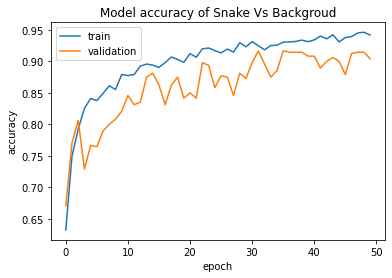

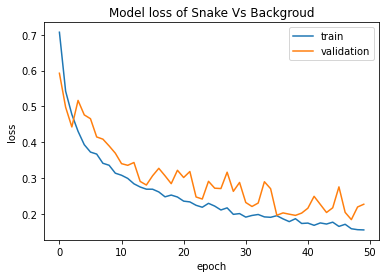

In [34]:
############################################
#Plot the Graph

acc = H.history['acc']
val_acc = H.history['val_acc']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy of Snake Vs Backgroud')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('acc.png')
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss of Snake Vs Backgroud')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('loss.png')
plt.show()

In [3]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("evaluating after fine-tuning network head...")

totalTest=200
testGen.reset()
predIdxs = model.predict(x=testGen, steps=(totalTest // batch_size) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
    target_names=testGen.class_indices.keys()))

evaluating after fine-tuning network head...


NameError: name 'testGen' is not defined

In [4]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix of snake Vs background', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.figure(figsize=(8,8))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   

#thresh = cm.max() / 2.
#Matplotlib’s matshow
cm = confusion_matrix(testGen.classes, predIdxs)

plt.figure(3)
plot_confusion_matrix(cm, target_names, title='Confusion matrix of snake Vs Backgroud')
#print(cm)
plt.savefig('snake_Resnet.png')
plt.show()

NameError: name 'testGen' is not defined